# estimate $p(M_*, M_h | {\rm photometry})$ using NPE for central subhalos
using forward modeled photometry constructed from TNG subhalos

In [1]:
import os, h5py
import numpy as np
from astropy import table as aTable
from tqdm.notebook import tqdm, trange

In [2]:
import torch 
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
# -- plotting -- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

## read in central galaxies train/test datasets at $z=0.1$

In [4]:
subhalo_train = aTable.Table.read('/Users/chahah/data/frb_halos/subhalos.central.snapshot91.train.csv')
subhalo_test = aTable.Table.read('/Users/chahah/data/frb_halos/subhalos.central.snapshot91.test.csv')

In [5]:
subhalo_train[:5]

g_Sersic_Reff,g_Sersic_mag,g_Sersic_dmag_m,g_Sersic_dmag_p,g_CAS_C,g_CAS_A,snapshot,subhalo_id,version,i_Sersic_Reff,i_Sersic_mag,i_Sersic_dmag_m,i_Sersic_dmag_p,i_CAS_C,i_CAS_A,r_Sersic_Reff,r_Sersic_mag,r_Sersic_dmag_m,r_Sersic_dmag_p,r_CAS_C,r_CAS_A,y_Sersic_Reff,y_Sersic_mag,y_Sersic_dmag_m,y_Sersic_dmag_p,y_CAS_C,y_CAS_A,z_Sersic_Reff,z_Sersic_mag,z_Sersic_dmag_m,z_Sersic_dmag_p,z_CAS_C,z_CAS_A,SubhaloMassType_stars,SubhaloMassType_dm
float64,float64,float64,float64,float64,float64,int64,int64,str2,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
19.3399,13.3532,-0.000235766,0.000968579,5.48404,0.128438,91,0,v3,19.0344,11.9149,-0.00614352,0.0441109,5.5885,0.151465,19.3865,12.4089,-0.00406867,0.000176909,5.48404,0.135967,18.6958,11.5054,-0.017918,0.25913,5.5386,0.135583,18.4421,11.6366,-0.0187289,0.160165,5.64329,0.1419,12.7342,14.2415
17.8423,13.3935,-0.00436186,0.00183683,5.38695,0.0904381,91,0,v2,15.5692,12.0187,-0.009137,0.0291452,5.55585,0.0861324,15.5731,12.5123,-0.000620076,0.00299924,5.38695,0.0893994,14.8731,11.6315,-0.0169273,0.0366591,5.45017,0.0698951,15.6444,11.7254,-0.000748302,0.00353526,5.55585,0.0778021,12.7342,14.2415
19.4988,13.3941,-0.0634623,0.0803728,5.53764,0.103165,91,0,v1,18.8773,11.9666,-0.058396,0.0774409,5.69275,0.129235,16.3905,12.5511,-0.167439,0.0408123,5.53764,0.106361,20.3895,11.5183,-0.0408704,0.0943793,5.64329,0.0945187,21.5618,11.5932,-0.00577006,0.00813687,5.69275,0.119082,12.7342,14.2415
17.4816,13.4667,-0.00148941,0.00169452,5.5386,0.0655124,91,0,v0,17.4199,12.0365,-0.00046291,0.000525119,5.70243,0.0809164,17.6987,12.5213,-0.019676,0.0129239,5.5386,0.0727035,17.8812,11.6088,-0.00314681,0.00136466,5.43369,0.0659247,17.103,11.7548,-0.00131203,0.00228339,5.70243,0.0771571,12.7342,14.2415
8.35114,14.371,-0.000231679,0.000353278,3.76913,0.156349,91,70250,v0,4.53555,13.381,-6.8082e-05,8.51091e-05,4.22041,0.119823,5.25201,13.7941,-0.00479618,0.002363,4.02414,0.132992,4.35746,12.9981,-0.000605105,0.000244437,3.98999,0.0989417,4.71643,13.0892,-0.000294769,0.000150397,4.1056,0.10153,12.1915,13.8559


## set up train/test dataset
Our photometric observables are: 
- `Sersic_Reff` (arcsec) 
- `Sersic_mag` 
- `CAS_C` (concentration)
- `CAS_A` (asymmetry)
for the g, i, r, y, z bands

In [6]:
cols = []
for b in ['g', 'r', 'i', 'y', 'z']: 
    for p in ['Sersic_Reff', 'Sersic_mag', 'CAS_C', 'CAS_A']: 
        cols.append('%s_%s' % (b, p))

In [7]:
y_test = np.array([np.array(subhalo_test[col].data) for col in ['SubhaloMassType_stars', 'SubhaloMassType_dm']]).T
x_test = np.array([np.array(subhalo_test[col].data) for col in cols]).T

y_train = np.array([np.array(subhalo_train[col].data) for col in ['SubhaloMassType_stars', 'SubhaloMassType_dm']]).T
x_train = np.array([np.array(subhalo_train[col].data) for col in cols]).T

(9.0, 15.0)

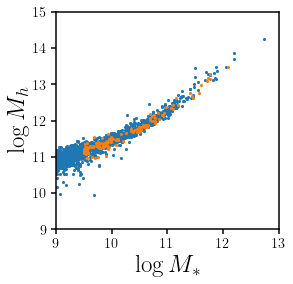

In [8]:
fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)
sub.scatter(y_train[:,0], y_train[:,1], s=2)
sub.scatter(y_test[:,0], y_test[:,1], s=2)

sub.set_xlabel(r'$\log M_*$', fontsize=25)
sub.set_xlim(9., 13)
sub.set_ylabel(r'$\log M_h$', fontsize=25)
sub.set_ylim(9., 15.)

# train NPE
We use a Masked Autoregressive Flow. We train 3 NPEs with random architectures with a 90/10 training/validation split and pick the NPE with the best validation loss. 

In [9]:
lower_bounds = torch.tensor([9., 9.]) # training set only includes galaxies with logMstar/Mun > 9
upper_bounds = torch.tensor([14., 15.])

prior = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

In [10]:
fnpe = '/Users/chahah/data/frb_halos/npe.pt'

# train multiple NPEs and pick the best one
anpes, phats = [], []
valid_logprobs, best_valid_logprobs = [], []
archs = []
for i in range(10):
    nhidden = int(np.ceil(np.exp(np.random.uniform(np.log(64), np.log(128)))))
    nblocks = int(np.random.uniform(3, 10))
    print('\n MAF with nhidden=%i; nblocks=%i' % (nhidden, nblocks))
    archs.append('%ix%i' % (nhidden, nblocks))

    anpe = Inference.SNPE(prior=prior,
                          density_estimator=Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks),
                          device='cpu')
    anpe.append_simulations(
        torch.as_tensor(y_train.astype(np.float32)),
        torch.as_tensor(x_train.astype(np.float32)))

    _phat = anpe.train()

    p_y_x_est = anpe.build_posterior(_phat)

    anpes.append(anpe)
    phats.append(p_y_x_est)

    valid_logprobs.append(anpe._summary['validation_log_probs'])
    best_valid_logprobs.append(anpe._summary['best_validation_log_probs'])

ibest = np.argmax(best_valid_logprobs)
best_anpe = anpes[ibest]
best_phat = phats[ibest]
best_arch = archs[ibest]

torch.save(best_phat, fnpe)


 MAF with nhidden=117; nblocks=8
 Neural network successfully converged after 75 epochs.
 MAF with nhidden=119; nblocks=8
 Neural network successfully converged after 111 epochs.
 MAF with nhidden=77; nblocks=7
 Neural network successfully converged after 68 epochs.
 MAF with nhidden=127; nblocks=8
 Neural network successfully converged after 79 epochs.
 MAF with nhidden=75; nblocks=6
 Neural network successfully converged after 90 epochs.
 MAF with nhidden=95; nblocks=6
 Neural network successfully converged after 52 epochs.
 MAF with nhidden=67; nblocks=6
 Neural network successfully converged after 68 epochs.
 MAF with nhidden=76; nblocks=6
 Neural network successfully converged after 74 epochs.
 MAF with nhidden=89; nblocks=6
 Neural network successfully converged after 81 epochs.
 MAF with nhidden=72; nblocks=4
 Neural network successfully converged after 85 epochs.

Text(0, 0.5, '-log validation likelihood')

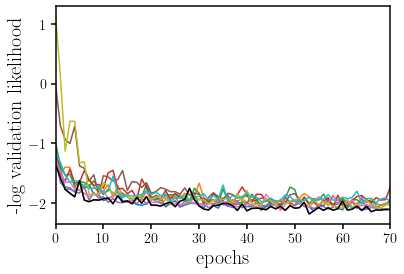

In [11]:
for vl in valid_logprobs: 
    plt.plot(-np.array(vl))
    plt.xlim(0., 70)
plt.plot(-np.array(valid_logprobs[ibest]), c='k')
plt.xlabel('epochs', fontsize=20)
plt.ylabel('-log validation likelihood', fontsize=20)

# validate NPE on test set

First lets examine the NPE posteriors for a handful of galaxies

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[10.4792 11.7571]
sigma_logM* = 0.0769
sigma_logMh = 0.1145


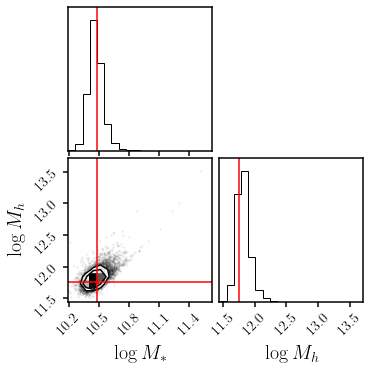

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.54198 11.0702 ]
sigma_logM* = 0.1115
sigma_logMh = 0.0629


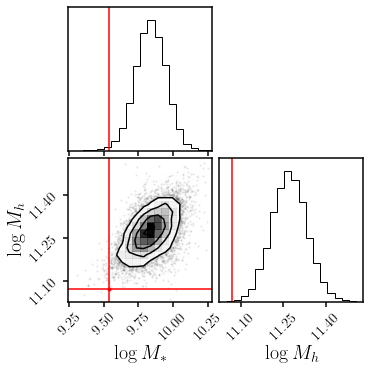

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.67331 11.2835 ]
sigma_logM* = 0.0692
sigma_logMh = 0.0959


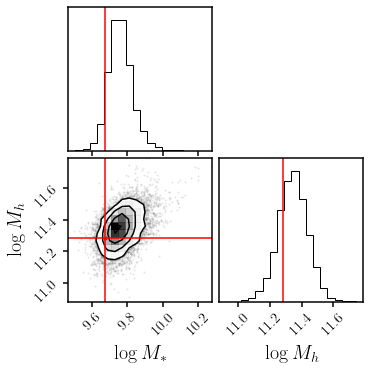

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.7193 11.3853]
sigma_logM* = 0.0718
sigma_logMh = 0.1031


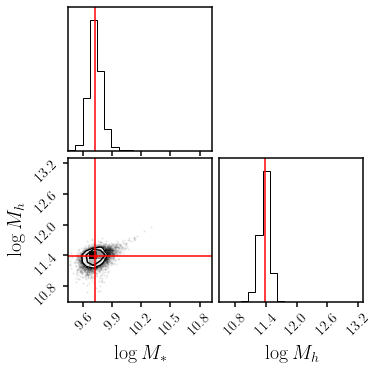

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[10.4502 11.7713]
sigma_logM* = 0.0760
sigma_logMh = 0.1230


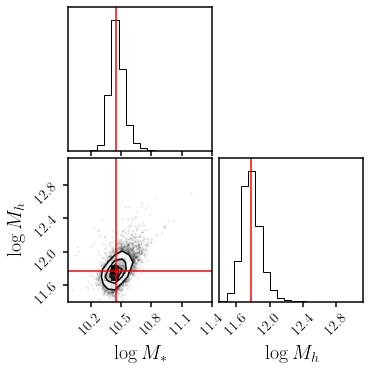

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.77528 11.2343 ]
sigma_logM* = 0.0719
sigma_logMh = 0.0903


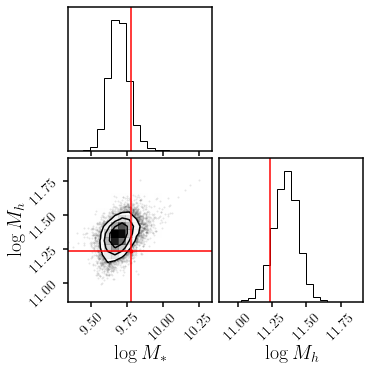

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.8937 11.3862]
sigma_logM* = 0.0566
sigma_logMh = 0.0980


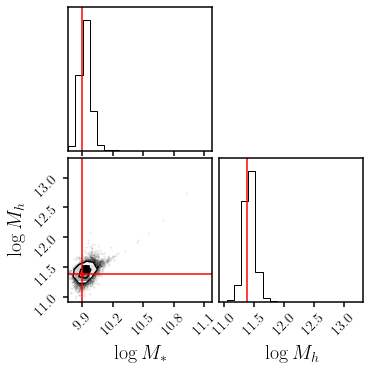

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[10.6891 12.1906]
sigma_logM* = 0.1038
sigma_logMh = 0.1334


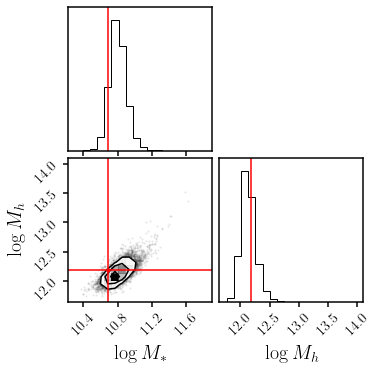

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[ 9.55969 11.2158 ]
sigma_logM* = 0.0612
sigma_logMh = 0.1015


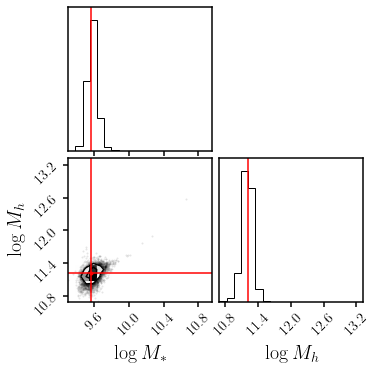

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

[10.4815 11.7003]
sigma_logM* = 0.0909
sigma_logMh = 0.1321


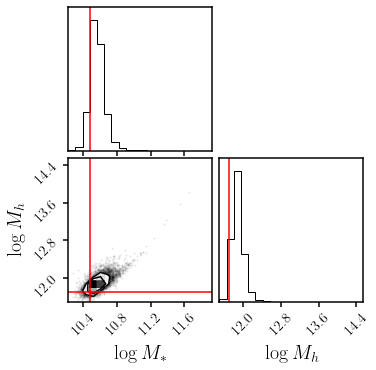

In [12]:
for i in np.random.choice(np.arange(x_test.shape[0]), size=10, replace=False): 
    _x, _y = x_test[i], y_test[i]

    # sample posterior p(theta | x)
    mcmc_npe = best_phat.sample((10000,),
            x=torch.as_tensor(_x.astype(np.float32)).to('cpu'),
            show_progress_bars=True)
    mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))
    
    print(_y)
    print('sigma_logM* = %.4f' % np.std(mcmc_npe, axis=0)[0])
    print('sigma_logMh = %.4f' % np.std(mcmc_npe, axis=0)[1])

    fig = DFM.corner(mcmc_npe, 
                     labels=[r'$\log M_*$', r'$\log M_h$'], 
                     label_kwargs={'fontsize': 20})
    DFM.overplot_points(fig, [_y], color='r')
    DFM.overplot_lines(fig, _y, color='r')
    plt.show()

now lets quantitatively validate the quality of the NPE posteriors using Simulation-Based Calibration (Talts et al. 2020)

In [13]:
ranks_logms, sigma_logms = [], [] 
ranks_logmh, sigma_logmh = [], [] 
for _x, _y in zip(x_test, y_test): 
    if _y[0] > 12: continue
    # sample posterior p(theta | x)
    mcmc_npe = best_phat.sample((10000,),
            x=torch.as_tensor(_x.astype(np.float32)).to('cpu'),
            show_progress_bars=False)
    mcmc_npe = np.array(mcmc_npe.detach().to('cpu'))
    
    ranks_logms.append(np.sum(mcmc_npe[:,0] < _y[0]))
    sigma_logms.append(np.std(mcmc_npe, axis=0)[0])
    
    ranks_logmh.append(np.sum(mcmc_npe[:,1] < _y[1]))
    sigma_logmh.append(np.std(mcmc_npe, axis=0)[1])

(0.0, 2.0)

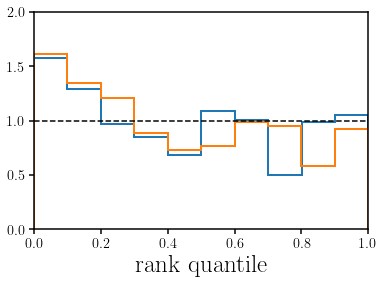

In [14]:
fig = plt.figure(figsize=(6, 4))
sub = fig.add_subplot(111)
_ = sub.hist(np.array(ranks_logms)/10000., density=True, histtype='step', linewidth=2)
_ = sub.hist(np.array(ranks_logmh)/10000., density=True, histtype='step', linewidth=2)
sub.plot([0., 1.], [1., 1.], c='k', ls='--')
sub.set_xlabel('rank quantile', fontsize=25)
sub.set_xlim(0, 1.)
sub.set_ylim(0., 2.)

Not bad. NPEs infer more or less unbiased posteriors on $\log M_*$ and $\log M_h$. 

## check precision of posteriors

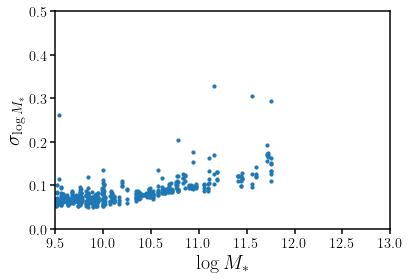

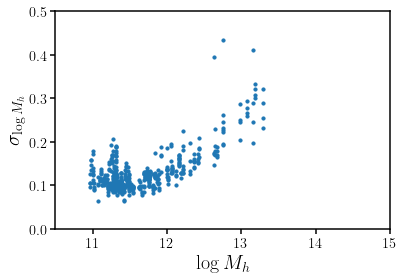

In [15]:
plt.scatter(y_test[:,0][y_test[:,0] <= 12.], sigma_logms, s=10)
plt.xlabel(r'$\log M_*$', fontsize=20)
plt.xlim(9.5, 13.)
plt.ylabel(r'$\sigma_{\log M_*}$', fontsize=20)
plt.ylim(0., 0.5)
plt.show()

plt.scatter(y_test[:,1][y_test[:,0] <= 12.], sigma_logmh, s=10)
plt.xlabel(r'$\log M_h$', fontsize=20)
plt.xlim(10.5, 15.)
plt.ylabel(r'$\sigma_{\log M_h}$', fontsize=20)
plt.ylim(0., 0.5)
plt.show()

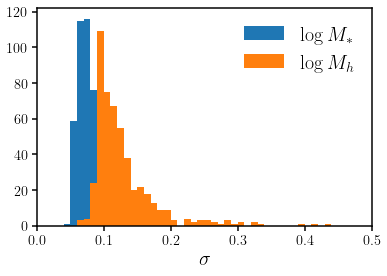

In [16]:
plt.hist(sigma_logms, range=(0., 1.), bins=100, label=r'$\log M_*$')
plt.hist(sigma_logmh, range=(0., 1.), bins=100, label=r'$\log M_h$')
#plt.vlines(0.1, 0., 70, color='k', linestyle='--')
plt.xlabel(r'$\sigma$', fontsize=20)
plt.xlim(0., 0.5)
plt.legend(loc='upper right', fontsize=20)

In [17]:
np.median(sigma_logms), np.median(sigma_logmh)

(0.07626217, 0.11471606)